# Ensemble Groundwater Predictions (EGP)
*R.A. Collenteur, Eawag, 2025*

This notebook shows how to use Pastas and meteorological ensemble forecasts to generate ensemble groundwater predictions (EGPs). The goal is to forecast the groundwater levels for a well in Switzerland (Gossau), one month ahead. Meteorological ensemble forecasts of the ECMWF with 51 ensemble members are used as data input. These members represent the uncertainty in the meteorological input data. 

The Pastas model is calibrated on 10 years of head data prior to the start of the forecast, using meteorological data provided by MeteoSwiss. In this example, meteorological forecasts are used, but it is straightforward to extend this to other input data such as ensembles of pumping forecasts.

<div class="alert alert-info">
<b>Note:</b>
Collenteur et al. (In submission) Ensemble groundwater predictions (EGP) in alluvial aquifers in Switzerland.
</div>

## 0. Import Python Packages

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pastas as ps

ps.set_log_level("ERROR")
ps.show_versions()

Pastas version: 1.11.0.dev0
Python version: 3.10.14
NumPy version: 1.24.4
Pandas version: 2.2.2
SciPy version: 1.14.1
Matplotlib version: 3.8.4
Numba version: 0.59.1


## 1. Load data

Below the head and meteorological data is loaded for the well in Gossau, Switzerland.



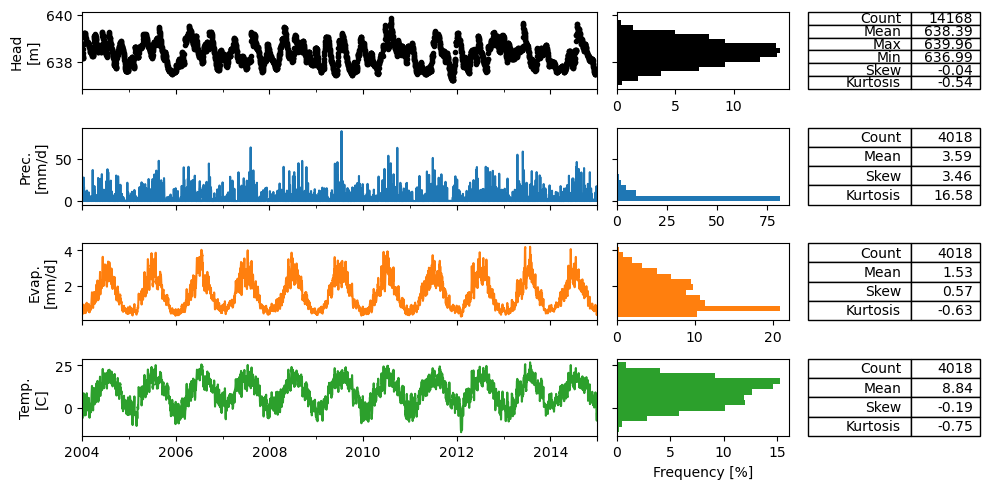

In [22]:
head = pd.read_csv("data_forecast/heads.csv", index_col=0, parse_dates=True).squeeze()
prec = pd.read_csv("data_forecast/prec.csv", index_col=0, parse_dates=True).squeeze()
evap = pd.read_csv("data_forecast/evap.csv", index_col=0, parse_dates=True).squeeze()
temp = pd.read_csv("data_forecast/temp.csv", index_col=0, parse_dates=True).squeeze()

ps.plots.series(
    head,
    [prec, evap, temp],
    tmin="2004",
    tmax="2014",
    titles=False,
    labels=["Head\n[m]", "Prec.\n[mm/d]", "Evap.\n[mm/d]", "Temp.\n[C]"],
    table=True,
)
plt.tight_layout()

## Make Pastas Model

We now make a Pastas model to simulate the heads for this monitoring well in Gossau. Only meterological data, which is also available as forecast data, is used to model the groundwater levels. A nonlinear recharge model including a snow module is applied to compute the recharge. The model is calibrated on weekly groundwater level data in the period 2004-2014.

In [28]:
ml = ps.Model(head)
ml.add_stressmodel(
    ps.RechargeModel(
        prec,
        evap,
        rfunc=ps.Gamma(),
        recharge=ps.rch.FlexModel(snow=True),
        temp=temp,
        name="rch",
    )
)

ml.set_parameter("rch_tt", vary=False)
ml.solve(
    tmin="2004", tmax="2014-02-01", report=True, fit_constant=False, freq_obs="10D"
)
ml.add_noisemodel(ps.ArNoiseModel())
ml.set_parameter("rch_srmax", vary=False)
ml.solve(
    tmin="2004", tmax="2014-02-01", initial=False, fit_constant=False, freq_obs="10D"
)

Fit report Gossau                 Fit Statistics
nfev    49                     EVP         80.93
nobs    370                    R2           0.81
noise   False                  RMSE         0.21
tmin    2004-01-01 00:00:00    AICc     -1142.10
tmax    2014-02-01 00:00:00    BIC      -1111.19
freq    D                      Obj          8.08
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (8 optimized)
               optimal     initial   vary
rch_A         0.457980    0.405356   True
rch_n         1.258573    1.000000   True
rch_a        19.915905   10.000000   True
rch_srmax    75.117392  250.000000   True
rch_lp        0.250000    0.250000  False
rch_ks       34.067643  100.000000   True
rch_gamma     8.244970    2.000000   True
rch_kv        1.090291    1.000000   True
rch_simax     2.000000    2.000000  False
rch_tt        0.000000    0.000000  False
rch_k         5.484702    2.000000   True
constant_d  637.516541    0.0

### Visualize the model results

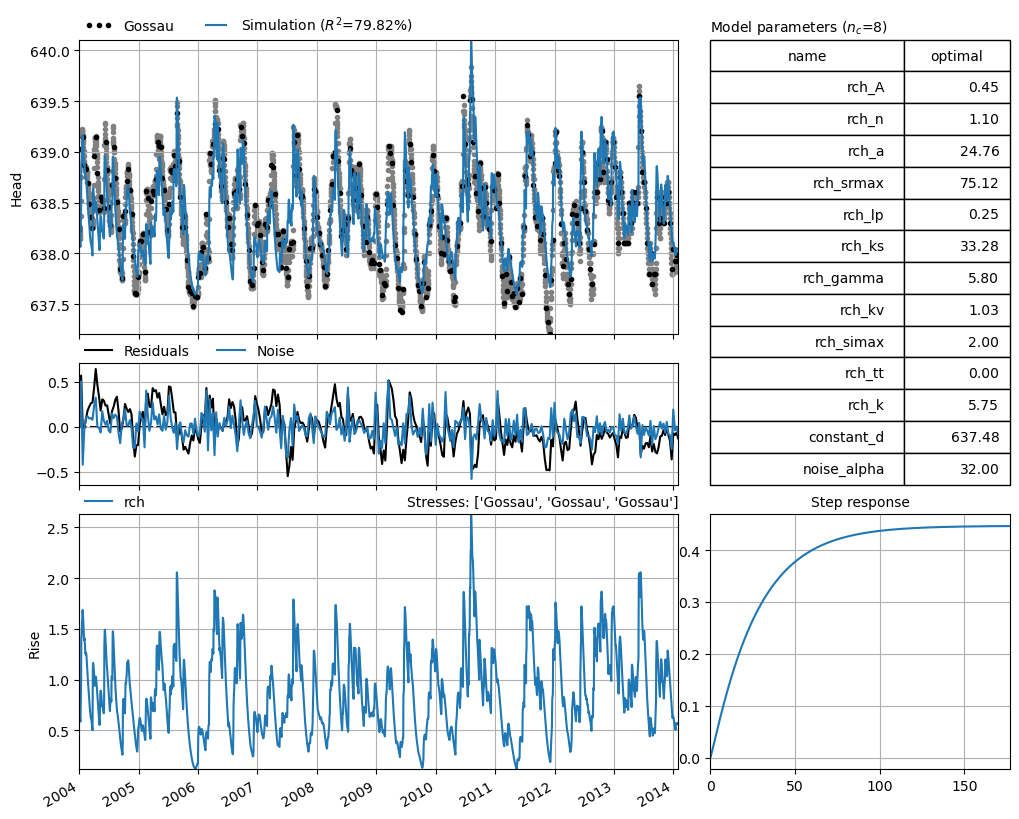

In [29]:
ml.plots.results();

## Prepare the forecast ensembles

Now that we have a calibrated Pastas model, we can prepare the forecast data used to generate the groundwater ensemble predictions. The forecast data should be prepared carefully as a dictionary. For each stressmodel, one item in the dictionary should be provided where the `key` is the stressmodel name (i.e., same as in `ml.stressmodels`) and the `value` a list of `pandas.DataFrames`. 

Each `DataFrame` should have the same `DateimeIndex` with the dates of the forecasts of the input data. It should also have the same number of columns, where each column represents an ensemble member (i.e., the precipitation and evaporation data need the same number of members). All these properties are internally checked by the internal method `ps.forecast._check_forecast_data` and an error is raised if something is wrong.

<function pastas.forecast._check_forecast_data(forecasts: Dict[str, List[pandas.core.frame.DataFrame]]) -> Tuple[int, Any, Any, pandas.core.indexes.datetimes.DatetimeIndex]>

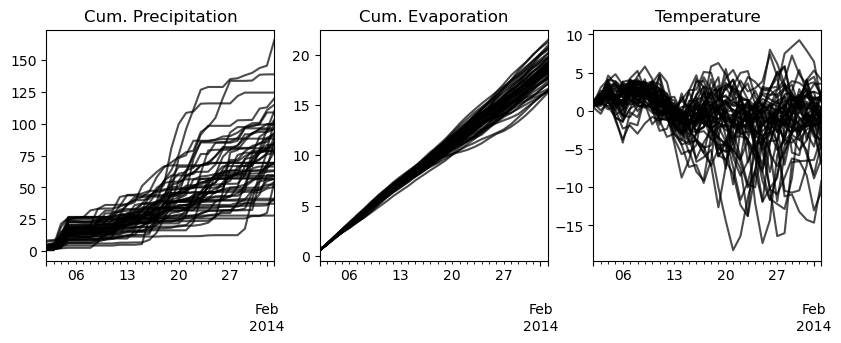

In [30]:
fc = {
    "rch": [
        pd.read_csv("data_forecast/ensemble_prec.csv", index_col=0, parse_dates=True),
        pd.read_csv("data_forecast/ensemble_evap.csv", index_col=0, parse_dates=True),
        pd.read_csv("data_forecast/ensemble_temp.csv", index_col=0, parse_dates=True),
    ]
}

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
names = ["Cum. Precipitation", "Cum. Evaporation", "Temperature"]
for i in range(3):
    series = fc["rch"][i]
    if i < 2:
        series.cumsum().plot(legend=False, ax=axes[i], color="k", alpha=0.7)
    else:
        series.plot(legend=False, ax=axes[i], color="k", alpha=0.7)

    axes[i].set_title(names[i])

ps.forecast._check_forecast_data

## Compute GWL forecasts

We can now generate the forecasts of the groundwater levels using the calibrated model. We can include the parameter uncertainty, by drawing multiple parameter sets (i.e., $N$ parameter sets). The model is run with each of the $N$ parameter sets for all $M$ ensemble member sets (i.e., set of precipitation, evaporation and temperature), resulting in $N$ x $M$ forecasts. 

For each individual forecast the mean forecast and the variance of the error or noise is returned, depending on whether or not `post_process` is `True` or `False`. If `True`, the forecast is:

1) corrected using the last GWL measurement and the fitted noisemodel, and 
2) the variance of the error is computed using the noise and the noisemodel. 

If `False`, the forecast is not corrected and the variance of the residuals is returned. Thus, for each combination of a forecast of the ensemble members and the parameter sets a mean forecast and the variance of theb forecast is returned. These can be used to compute a prediction interval.

In [31]:
# Draw parameter sets
params = ml.solver.get_parameter_sample(n=10)

# Generate the forecast
df_nopp = ps.forecast.forecast(ml, fc, params=params, post_process=False)
df_pp = ps.forecast.forecast(ml, fc, params=params, post_process=True)

df_pp.head()

ensemble_member          0                                               \
param_member              0                     1                     2   
forecast               mean       var        mean       var        mean   
2014-01-02       638.029352  0.002894  638.026725  0.002802  638.027558   
2014-01-03       638.022119  0.005608  638.018554  0.005458  638.019300   
2014-01-04       638.014170  0.008153  638.009769  0.007976  638.010267   
2014-01-05       638.006634  0.010539  638.001589  0.010364  638.001409   
2014-01-06       638.021088  0.012777  638.014389  0.012628  638.013826   

ensemble_member                                                        ...  \
param_member                        3                     4            ...   
forecast              var        mean       var        mean       var  ...   
2014-01-02       0.003024  638.035067  0.002885  638.031720  0.002793  ...   
2014-01-03       0.005842  638.030830  0.005598  638.025845  0.005428  ...   
2014-01-04       0.008469  638.025718  0.008149  638.019171  0.007915  ...   
2014-01-05       0.010917  638.020951  0.010548  638.012771  0.010262  ...   
2014-01-06       0.013198  638.040736  0.012803  638.025393  0.012476  ...   

ensemble_member          50                                              \
param_member              5                     6                     7   
forecast               mean       var        mean       var        mean   
2014-01-02       638.034060  0.002976  638.029891  0.002744  638.033126   
2014-01-03       638.032927  0.005747  638.026318  0.005342  638.030700   
2014-01-04       638.029691  0.008328  638.021089  0.007802  638.026713   
2014-01-05       638.091683  0.010730  638.074514  0.010131  638.085133   
2014-01-06       638.141476  0.012967  638.122431  0.012337  638.135897   

ensemble_member                                                        
param_member                        8                     9            
forecast              var        mean       var        mean       var  
2014-01-02       0.003055  638.030215  0.002818  638.029281  0.002772  
2014-01-03       0.005887  638.026736  0.005467  638.025975  0.005395  
2014-01-04       0.008513  638.021652  0.007956  638.020687  0.007875  
2014-01-05       0.010948  638.073236  0.010296  638.074184  0.010221  
2014-01-06       0.013206  638.120156  0.012495  638.119992  0.012440  

[5 rows x 1020 columns]

The returned variable `df` is a DataFrame containing the ensemble groundwater predictions. The columns of `df` are a `MultiIndex` with the first row the $M$ ensemble members (i.e., a single meteorological forecast), the second row the $N$ parameter sets, and the third row three columns with the mean prediction and the variance of the error that can be used to construct the prediction interval. 

## Compute the overall mean and variance

The forecast method returns a matrix with with $N$ x $M$ forecasts of the mean and variance. From these, we can compute the mean forecast over all ensembles and parameter sets easily. For the variance, which we use to compute the (for example) the 95\% prediction interval, we apply the law of total variance. The forecast method provides a convenience method to do this: `ps.forecast.get_overall_mean_and_variance`. The method takes the output dataframe `df` and returns two `pandas.Series` with the overall mean and the variance.

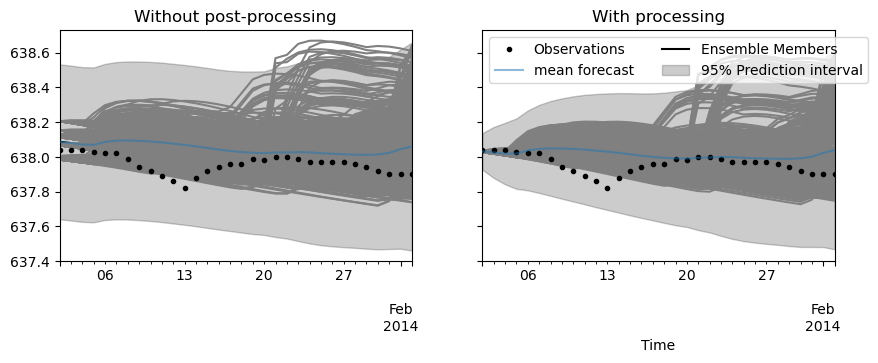

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

suptitles = ["Without post-processing", "With processing"]

for i, (df, label) in enumerate(zip([df_nopp, df_pp], ["No PP", "PP"])):
    mean, var = ps.forecast.get_overall_mean_and_variance(df)
    std = np.sqrt(var)

    ax = axes[i]
    ml.oseries.series.loc[df.index].plot(
        ax=ax, marker=".", color="k", linestyle="None", zorder=100
    )

    mean.plot(ax=ax, alpha=0.5, zorder=100)
    ax.plot(mean, color="k", label="Mean")
    ax.fill_between(
        mean.index,
        mean - std * 1.96,
        mean + std * 1.96,
        color="k",
        alpha=0.2,
        label="1 std",
    )

    df.loc[:, (slice(None), slice(None), "mean")].plot(
        color="gray", legend=False, ax=ax
    )
    ax.set_title(suptitles[i])

plt.legend(
    ["Observations", "mean forecast", "Ensemble Members", "95% Prediction interval"],
    loc="upper left",
    ncol=2,
)

plt.xlabel("Time")
plt.ylabel("Head [m]");

In the figure above we see the two ensemble predictions, without (left) and with (right) post-processing. What we can see is that the prediction intervals widen over time when using the post/processing, whereas without it, these remain more stable and only widen due to the increased uncerainty in the ensemble members. In general, we can see that the largest part of the uncertainty is due to the uncertainty in the input data, as visible bz the mean forecasts of the ensemble members (the grey lines) covering a large part of the prediction intervals.
